## IMPORTING DATA

In [26]:
import pandas as pd
import re

In [27]:
df = pd.read_csv("twitter_training.csv", header=None, names=["id", "topic", "sentiment", "tweet"], nrows=20000)
df = df[df["sentiment"].isin(["Positive", "Negative", "Neutral"])]

label_map = {"Negative": 0,"Neutral": 1, "Positive": 2}
df["label"] = df["sentiment"].map(label_map)

# PREPROCESSING DATA

In [28]:
def clean_tweet(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"\[UNK\]", "", text)
    text = re.sub(r"[^\w\s.,!?]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip().lower()

In [29]:
df["tweet"] = df["tweet"].astype(str).apply(clean_tweet)


df = df[["tweet", "label"]]
df = df.rename(columns={"tweet": "text"})


print(df.shape)
df.sample(5)

(16448, 2)


,text,label
5601,this was selling like 144 usd and is likely th...,2
10991,too bad much developers in the recent years ca...,0
1984,just nice.,2
1451,my,1
758,so the funny thing meatballmissus and i have j...,1


In [ ]:
df["label"].value_counts()

,count
label,
0,4674
2,4608
1,3612


# TRAIN TEST SPLIT

In [ ]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 10315, Test size: 2579


# IMPORTING NECESSARY LIBRARIES

In [ ]:
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch
from transformers import DistilBertTokenizer, DistilBertModel



# SETTING UP DEVICE TO GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## TOKENIZARION & PREPROCESSING FOR BERT MODEL

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(texts, labels):
    encodings = tokenizer(texts, padding="max_length", max_length=200, truncation=True, return_tensors="pt")
    return encodings["input_ids"], encodings["attention_mask"], torch.tensor(labels, dtype=torch.long)

train_input_ids, train_attention_mask, train_labels = tokenize_function(X_train.values.tolist(), y_train.values.tolist())
val_input_ids, val_attention_mask, val_labels = tokenize_function(X_test.values.tolist(), y_test.values.tolist())

# DATASETS AND DATA LOADERS

In [ ]:
train_dataset = torch.utils.data.TensorDataset(train_input_ids, train_attention_mask, train_labels)
val_dataset = torch.utils.data.TensorDataset(val_input_ids, val_attention_mask, val_labels)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# BERT MODEL

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self):
        super(SentimentClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")

        for param in self.bert.parameters():
            param.requires_grad = False  # Freeze BERT

        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 3)
        )

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sentence_embeddings = bert_output.last_hidden_state[:, 0, :]
        return self.classifier(sentence_embeddings)



In [ ]:
model = SentimentClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# TRAINING LOOP

In [ ]:
from tqdm import tqdm

epochs = 40
train_losses = []

for epoch in range(epochs):
    model.train()
    total_epoch_loss = 0

    for input_ids, attention_mask, labels in tqdm(train_loader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)


        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()

    avg_loss = total_epoch_loss/len(train_loader)
    print(f"EPOCH: {epoch+1}, LOSS: {avg_loss}")
    train_losses.append(avg_loss)

100%|██████████| 162/162 [00:59<00:00,  2.73it/s]


EPOCH: 1, LOSS: 0.8635298293313862


100%|██████████| 162/162 [01:03<00:00,  2.54it/s]


EPOCH: 2, LOSS: 0.7480901568024246


100%|██████████| 162/162 [01:02<00:00,  2.58it/s]


EPOCH: 3, LOSS: 0.7076760607737081


100%|██████████| 162/162 [01:02<00:00,  2.61it/s]


EPOCH: 4, LOSS: 0.6519434402386347


100%|██████████| 162/162 [01:02<00:00,  2.59it/s]


EPOCH: 5, LOSS: 0.6278001870270129


100%|██████████| 162/162 [01:02<00:00,  2.59it/s]


EPOCH: 6, LOSS: 0.5940407259780683


100%|██████████| 162/162 [01:02<00:00,  2.59it/s]


EPOCH: 7, LOSS: 0.5720378544963436


100%|██████████| 162/162 [01:02<00:00,  2.60it/s]


EPOCH: 8, LOSS: 0.5547549029191335


100%|██████████| 162/162 [01:02<00:00,  2.60it/s]


EPOCH: 9, LOSS: 0.5133681096780447


100%|██████████| 162/162 [01:02<00:00,  2.60it/s]


EPOCH: 10, LOSS: 0.5048954198021948


100%|██████████| 162/162 [01:02<00:00,  2.61it/s]


EPOCH: 11, LOSS: 0.49648875605176995


100%|██████████| 162/162 [01:02<00:00,  2.60it/s]


EPOCH: 12, LOSS: 0.4727249362586457


100%|██████████| 162/162 [01:02<00:00,  2.60it/s]


EPOCH: 13, LOSS: 0.45169883377758074


100%|██████████| 162/162 [01:02<00:00,  2.60it/s]


EPOCH: 14, LOSS: 0.44512496999016515


100%|██████████| 162/162 [01:02<00:00,  2.61it/s]


EPOCH: 15, LOSS: 0.42885947558614945


100%|██████████| 162/162 [01:02<00:00,  2.61it/s]


EPOCH: 16, LOSS: 0.4193551395042443


100%|██████████| 162/162 [01:02<00:00,  2.61it/s]


EPOCH: 17, LOSS: 0.39846395342438307


100%|██████████| 162/162 [01:02<00:00,  2.61it/s]


EPOCH: 18, LOSS: 0.40216764081039547


100%|██████████| 162/162 [01:02<00:00,  2.60it/s]


EPOCH: 19, LOSS: 0.39281953356148286


100%|██████████| 162/162 [01:02<00:00,  2.59it/s]


EPOCH: 20, LOSS: 0.37034682322431495


100%|██████████| 162/162 [01:02<00:00,  2.58it/s]


EPOCH: 21, LOSS: 0.3572723894023601


100%|██████████| 162/162 [01:02<00:00,  2.57it/s]


EPOCH: 22, LOSS: 0.3579809197489126


100%|██████████| 162/162 [01:02<00:00,  2.58it/s]


EPOCH: 23, LOSS: 0.3605943457395942


100%|██████████| 162/162 [01:02<00:00,  2.58it/s]


EPOCH: 24, LOSS: 0.33947128535788734


100%|██████████| 162/162 [01:02<00:00,  2.58it/s]


EPOCH: 25, LOSS: 0.325946150554551


100%|██████████| 162/162 [01:02<00:00,  2.58it/s]


EPOCH: 26, LOSS: 0.321742693859118


100%|██████████| 162/162 [01:02<00:00,  2.59it/s]


EPOCH: 27, LOSS: 0.3191423722439342


100%|██████████| 162/162 [01:02<00:00,  2.59it/s]


EPOCH: 28, LOSS: 0.31599042288683077


100%|██████████| 162/162 [01:02<00:00,  2.59it/s]


EPOCH: 29, LOSS: 0.30901605635881424


100%|██████████| 162/162 [01:02<00:00,  2.59it/s]


EPOCH: 30, LOSS: 0.2994360531001915


100%|██████████| 162/162 [01:02<00:00,  2.59it/s]


EPOCH: 31, LOSS: 0.29933117109316365


100%|██████████| 162/162 [01:02<00:00,  2.60it/s]


EPOCH: 32, LOSS: 0.30875196390681797


100%|██████████| 162/162 [01:02<00:00,  2.60it/s]


EPOCH: 33, LOSS: 0.28738711594983385


100%|██████████| 162/162 [01:02<00:00,  2.60it/s]


EPOCH: 34, LOSS: 0.28746022477194116


100%|██████████| 162/162 [01:02<00:00,  2.60it/s]


EPOCH: 35, LOSS: 0.28418087352205207


100%|██████████| 162/162 [01:02<00:00,  2.60it/s]


EPOCH: 36, LOSS: 0.2726544233291973


100%|██████████| 162/162 [01:02<00:00,  2.59it/s]


EPOCH: 37, LOSS: 0.2834072403701735


100%|██████████| 162/162 [01:02<00:00,  2.59it/s]


EPOCH: 38, LOSS: 0.2754906127114355


100%|██████████| 162/162 [01:02<00:00,  2.59it/s]


EPOCH: 39, LOSS: 0.2684616959757275


100%|██████████| 162/162 [01:02<00:00,  2.58it/s]

EPOCH: 40, LOSS: 0.2592676198684875


# EVALUATION LOOP

In [ ]:
model.eval()
total = 0
correct = 0
accuracies = []

with torch.no_grad():
    for input_ids, attention_mask, labels in tqdm(val_loader):

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask)
        _, predicted = torch.max(outputs, 1)

        total += labels.shape[0]
        correct += (predicted == labels).sum().item()
        accuracies.append(correct/total)

accuracy = correct/total
print(f"VALIDATION ACCURACY: {accuracy:.4f}")

100%|██████████| 41/41 [00:15<00:00,  2.68it/s]

VALIDATION ACCURACY: 0.9046


# VISUALISING THE PROCCESS

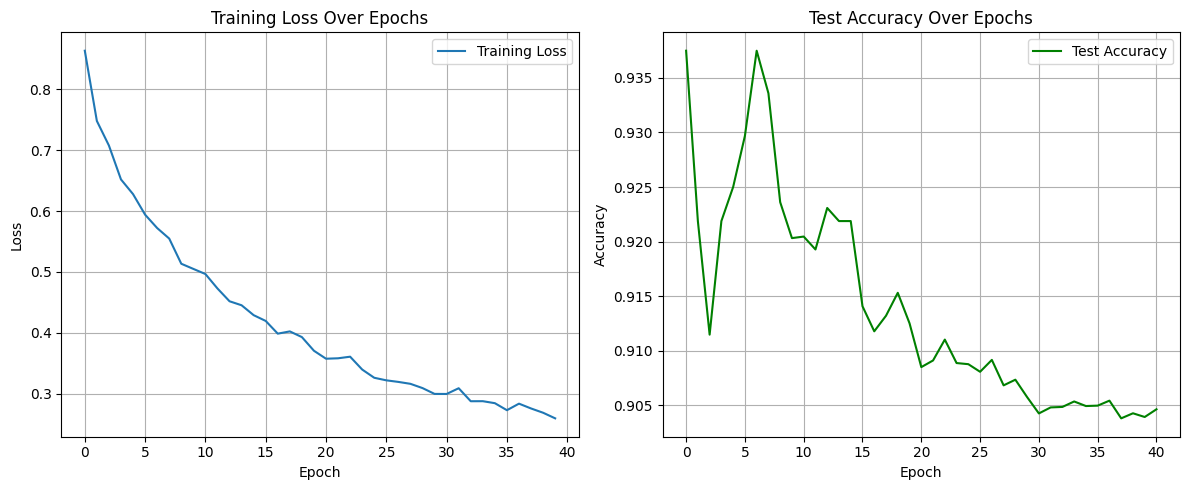

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# QUICK TEST OF THE MODEL

In [ ]:
import torch
import torch.nn.functional as F

def predict_sentiment(model, tokenizer, tweet, class_names=["Negative", "Neutral", "Positive"], device="cpu"):
    model.eval()
    model.to(device)


    inputs = tokenizer(
        tweet,
        padding="max_length",
        max_length=200,
        truncation=True,
        return_tensors="pt"
    )

    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probs = F.softmax(logits, dim=1)
        confidence, predicted_class = torch.max(probs, dim=1)

        label = class_names[predicted_class.item()]
        confidence_percent = confidence.item() * 100

    print(f"Tweet: {tweet}")
    print(f"Predicted: {label} ({confidence_percent:.2f}% confidence)\n")

    return label, confidence_percent


In [ ]:
test_tweets = [
    "I love this product! It works perfectly for my needs.",
    "This is the worst experience I've ever had with customer service.",
    "It's okay, nothing special but not terrible.",
    "Absolutely stunning performance by the actors, 10/10 would recommend."
]

for tweet in test_tweets:
    predict_sentiment(model, tokenizer, tweet)


Tweet: I love this product! It works perfectly for my needs.
Predicted: Positive (99.88% confidence)

Tweet: This is the worst experience I've ever had with customer service.
Predicted: Negative (98.96% confidence)

Tweet: It's okay, nothing special but not terrible.
Predicted: Positive (55.85% confidence)

Tweet: Absolutely stunning performance by the actors, 10/10 would recommend.
Predicted: Positive (65.02% confidence)



# SAVING THE MODEL AND TOKENIZER FILES

In [ ]:
torch.save(model.state_dict(), 'BERT_MODEL.pth')

In [ ]:
tokenizer.save_pretrained("TOKENIZER")

('TOKENIZER/tokenizer_config.json',
 'TOKENIZER/special_tokens_map.json',
 'TOKENIZER/vocab.txt',
 'TOKENIZER/added_tokens.json')

CONCLUSION : GOT THE PRETTY GOOD ACCURACY OF 90% OVER 40 EPOCHS, THE TRAINING OF THE MODEL SEEMS LITTLE BIT UNSTABLE BUT IT'S OKAY, FURTHER I WILL MAKE A STREAMLIT WEB APPLICATION FOR THIS MODEL
